# Inicio y carga

Aplanar, definir una resolución (128x128), kurtosis o skewness (columnas de pixeles) de cada componente.
analisis de cantidad de imagenes por categoria, y balancear los faltantes con aumento de imagenes.

Averiguar transformaciónes, resolución, contraste, invertir (mirror), rotar.
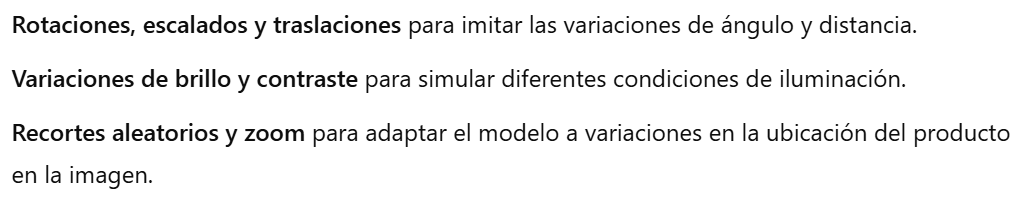


In [1]:
import numpy as np
import os
import pandas as pd
#imagenes
from PIL import Image
from skimage.feature import graycomatrix, graycoprops
#plots
import matplotlib.pyplot as plt
import seaborn as sns
#Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
ruta_carpeta='/content/drive/MyDrive/Maestria Andes/Applied data science/DS Taller 2 - images/GitImagenes/dataset/'
# ruta_carpeta='/content/drive/MyDrive/DS Taller 2 - images/GitImagenes/dataset/'
train_df=pd.read_csv(f'{ruta_carpeta}train.txt', header=None, names=['path','fine','coarse'])
test_df=pd.read_csv(f'{ruta_carpeta}test.txt', header=None, names=['path','fine','coarse'])
val_df=pd.read_csv(f'{ruta_carpeta}val.txt', header=None, names=['path','fine','coarse'])
clases_df=pd.read_csv(f'{ruta_carpeta}/classes.csv')

#Agregar el path inicial del drive
train_df['path']=train_df['path'].apply(lambda x: ruta_carpeta+x)
test_df['path']=test_df['path'].apply(lambda x: ruta_carpeta+x)
val_df['path']=val_df['path'].apply(lambda x: ruta_carpeta+x)

In [4]:
coarse_dic=clases_df[['Coarse Class ID (int)','Coarse Class Name (str)']].drop_duplicates().set_index('Coarse Class ID (int)').to_dict(orient='dict')['Coarse Class Name (str)']
fine_dic=clases_df[['Class ID (int)','Class Name (str)']].drop_duplicates().set_index('Class ID (int)').to_dict(orient='dict')['Class Name (str)']

train_df['coarse_str']=train_df['coarse'].map(coarse_dic)
train_df['fine_str']=train_df['fine'].map(fine_dic)

val_df['coarse_str']=val_df['coarse'].map(coarse_dic)
val_df['fine_str']=val_df['fine'].map(fine_dic)

test_df['coarse_str']=test_df['coarse'].map(coarse_dic)
test_df['fine_str']=test_df['fine'].map(fine_dic)

# Feature Engineering

In [5]:
def data_image(row):
  imagen = Image.open(row['path'])
  imagen = imagen.resize((32, 32))
  grey_matrix=np.array(imagen.convert("L"))
  grey=np.array(imagen.convert("L")).flatten()
  red, green, blue = zip(*[tupla for sublista in np.array(imagen) for tupla in sublista])
  return pd.Series([grey_matrix,grey, np.array(red),np.array(green),np.array(blue)], index=['grey_matrix','grey','red','green','blue'])

In [6]:
#single image
img_path=train_df['path'][0]
imagen = Image.open(img_path)
imagen = imagen.resize((32, 32))
imagen_array = np.array(imagen)
imagen_gris=np.array(imagen.convert("L")).flatten()
red, green, blue = zip(*[tupla for sublista in imagen_array for tupla in sublista])
imagen_gris, red, green, blue = imagen_gris/255, np.array(red)/255, np.array(green)/255, np.array(blue)/255
pd.DataFrame({'grey':imagen_gris,'red':red, 'green':green, 'blue':blue}).kurt()
# print(pd.DataFrame(list(red),list(green),list(blue)).kurt())

,0
grey,-1.051908
red,-0.708698
green,-1.076367
blue,-1.377579


In [7]:
train_df[['grey_matrix','grey','red','green','blue']]=train_df.apply(data_image, axis=1)
val_df[['grey_matrix','grey','red','green','blue']]=val_df.apply(data_image, axis=1)
test_df[['grey_matrix','grey','red','green','blue']]=test_df.apply(data_image, axis=1)

In [8]:
def image_kurtuosis(row):
  k=pd.DataFrame({'grey':row['grey'],'red':row['red'], 'green':row['green'], 'blue':row['blue']}).kurt()
  return pd.Series([k['grey'],k['red'],k['green'],k['blue']], index=['grey_kurtosis','red_kurtosis','green_kurtosis','blue_kurtosis'])

In [9]:
train_df[['grey_kurtosis','red_kurtosis','green_kurtosis','blue_kurtosis']]=train_df.apply(image_kurtuosis, axis=1)
val_df[['grey_kurtosis','red_kurtosis','green_kurtosis','blue_kurtosis']]=val_df.apply(image_kurtuosis, axis=1)
test_df[['grey_kurtosis','red_kurtosis','green_kurtosis','blue_kurtosis']]=test_df.apply(image_kurtuosis, axis=1)

In [10]:
def image_glcms(row):
  glcm = graycomatrix(row['grey_matrix'], distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
  contraste = graycoprops(glcm, 'contrast')[0, 0]
  uniformidad = graycoprops(glcm, 'energy')[0, 0]
  homogeneidad = graycoprops(glcm, 'homogeneity')[0, 0]
  return pd.Series([contraste,uniformidad,homogeneidad], index=['contraste','uniformidad','homogeneidad'])

In [11]:
train_df[['contraste','uniformidad','homogeneidad']]=train_df.apply(image_glcms, axis=1)
val_df[['contraste','uniformidad','homogeneidad']]=val_df.apply(image_glcms, axis=1)
test_df[['contraste','uniformidad','homogeneidad']]=test_df.apply(image_glcms, axis=1)

In [12]:
train_df.head()

,path,fine,coarse,coarse_str,fine_str,grey_matrix,grey,red,green,blue,grey_kurtosis,red_kurtosis,green_kurtosis,blue_kurtosis,contraste,uniformidad,homogeneidad
0,/content/drive/MyDrive/Maestria Andes/Applied ...,0,0,Apple,Golden-Delicious,"[[12, 42, 102, 56, 1, 11, 74, 89, 87, 36, 64, ...","[12, 42, 102, 56, 1, 11, 74, 89, 87, 36, 64, 9...","[15, 58, 121, 62, 0, 15, 90, 118, 134, 80, 123...","[11, 37, 95, 55, 2, 10, 69, 80, 70, 18, 39, 61...","[6, 29, 89, 49, 0, 6, 60, 62, 55, 16, 35, 48, ...",-1.051908,-0.708698,-1.076367,-1.377579,556.455645,0.027827,0.124594
1,/content/drive/MyDrive/Maestria Andes/Applied ...,0,0,Apple,Golden-Delicious,"[[67, 65, 71, 28, 19, 48, 84, 82, 116, 57, 40,...","[67, 65, 71, 28, 19, 48, 84, 82, 116, 57, 40, ...","[140, 130, 126, 64, 45, 106, 130, 136, 187, 10...","[35, 35, 44, 12, 8, 22, 64, 61, 89, 37, 31, 13...","[44, 45, 69, 18, 10, 28, 63, 48, 73, 40, 15, 3...",-0.787814,-0.791708,-0.810985,0.668261,1094.493952,0.024288,0.058947
2,/content/drive/MyDrive/Maestria Andes/Applied ...,0,0,Apple,Golden-Delicious,"[[51, 57, 94, 146, 139, 131, 135, 127, 113, 88...","[51, 57, 94, 146, 139, 131, 135, 127, 113, 88,...","[73, 76, 121, 181, 172, 165, 169, 157, 140, 10...","[49, 57, 96, 154, 147, 137, 142, 135, 120, 93,...","[3, 8, 15, 15, 11, 7, 10, 7, 4, 4, 2, 3, 9, 12...",-0.959247,-0.958286,-1.044863,3.813399,744.361895,0.023993,0.067393
3,/content/drive/MyDrive/Maestria Andes/Applied ...,0,0,Apple,Golden-Delicious,"[[125, 150, 152, 166, 187, 158, 142, 163, 167,...","[125, 150, 152, 166, 187, 158, 142, 163, 167, ...","[158, 177, 183, 196, 209, 186, 176, 188, 203, ...","[127, 154, 155, 170, 192, 162, 143, 158, 163, ...","[28, 59, 51, 68, 107, 67, 47, 122, 94, 73, 114...",-0.287243,-0.285457,-0.481658,1.969059,962.027218,0.024099,0.047391
4,/content/drive/MyDrive/Maestria Andes/Applied ...,0,0,Apple,Golden-Delicious,"[[40, 32, 32, 25, 35, 72, 77, 60, 55, 146, 154...","[40, 32, 32, 25, 35, 72, 77, 60, 55, 146, 154,...","[91, 79, 75, 61, 57, 85, 89, 72, 71, 181, 187,...","[18, 12, 14, 11, 27, 68, 74, 57, 57, 152, 161,...","[16, 12, 11, 7, 20, 55, 65, 44, 6, 21, 32, 21,...",-0.779205,-0.689181,-0.875360,2.397195,1221.640121,0.023919,0.050945


# EDA

In [13]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(2640, 17)
(296, 17)
(2485, 17)


### balance

In [14]:
print('Train coarse groups:',len(train_df['coarse'].unique()))
print('val coarse groups:',len(val_df['coarse'].unique()))
print('Test coarse groups:',len(test_df['coarse'].unique()),'\n')

print('Train fine groups:',len(train_df['fine'].unique()))
print('val fine groups:',len(val_df['fine'].unique()))
print('Test fine groups:',len(test_df['fine'].unique()))

Train coarse groups: 43
val coarse groups: 37
Test coarse groups: 43 

Train fine groups: 81
val fine groups: 60
Test fine groups: 81


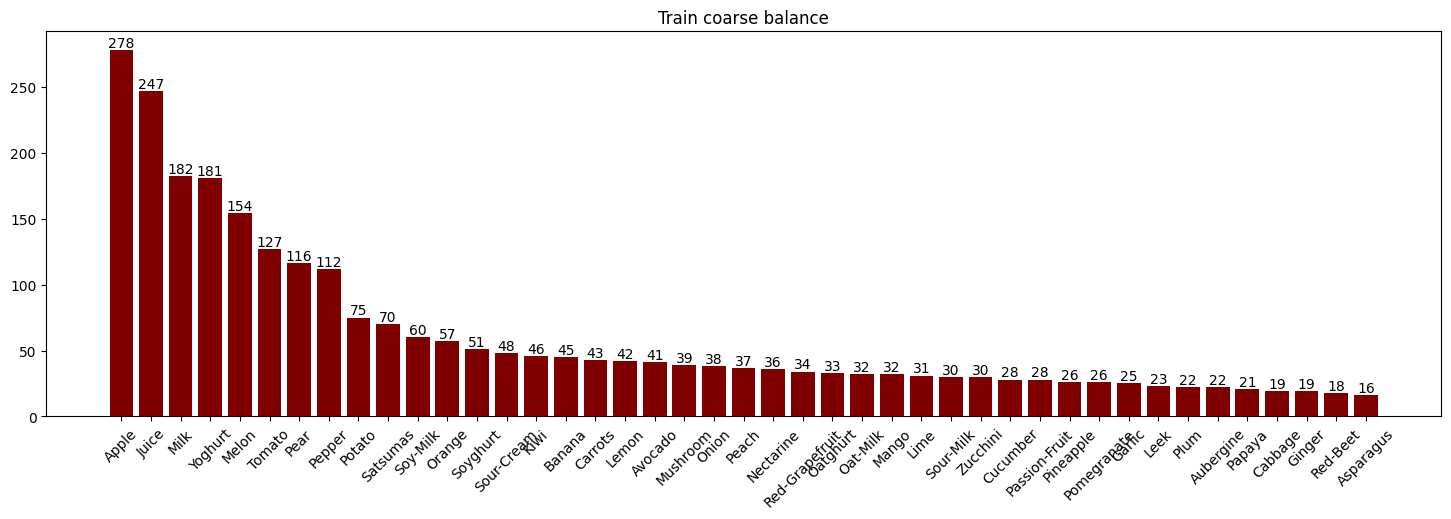

In [15]:
x=train_df['coarse_str'].value_counts()

fig, ax = plt.subplots(figsize = (18, 5))
bars = ax.bar(x.index, x.values, color ='maroon', width = 0.8)
ax.bar_label(bars)
plt.title('Train coarse balance')
plt.xticks(rotation=45)
plt.show()

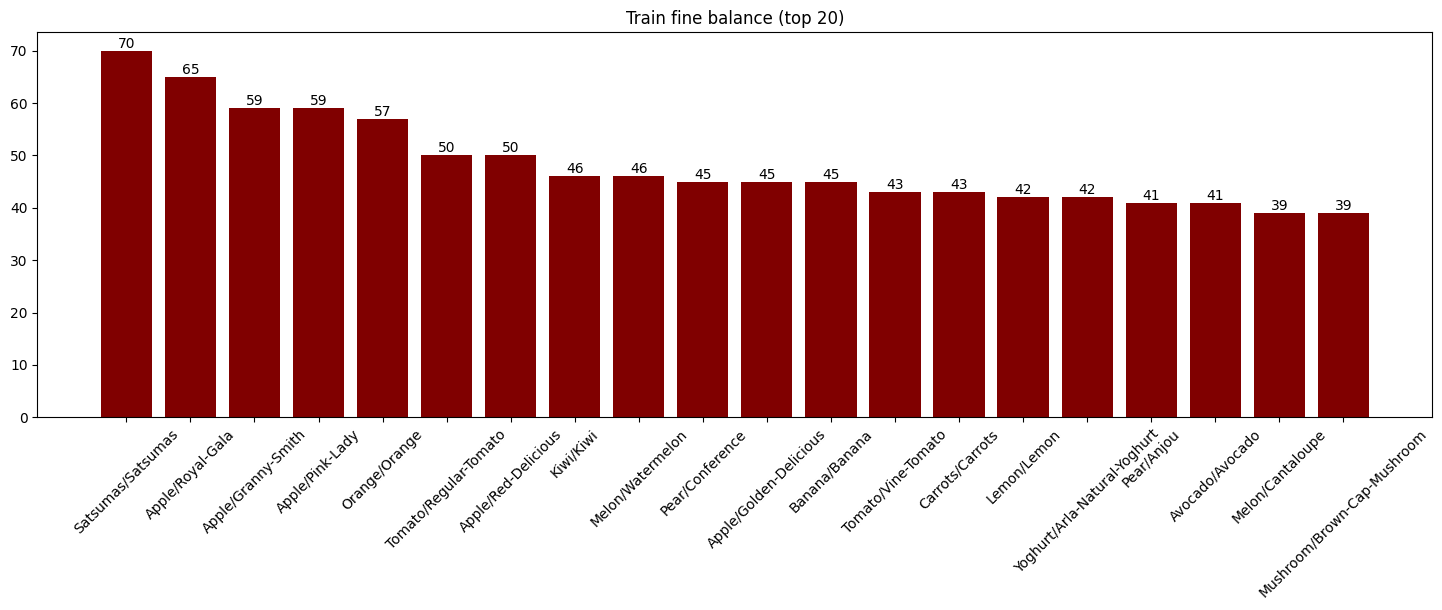

In [16]:
x=(train_df['coarse_str']+'/'+train_df['fine_str']).value_counts().head(20)

fig, ax = plt.subplots(figsize = (18, 5))
bars = ax.bar(x.index, x.values, color ='maroon', width = 0.8)
ax.bar_label(bars)
plt.title('Train fine balance (top 20)')
plt.xticks(rotation=45)
plt.show()

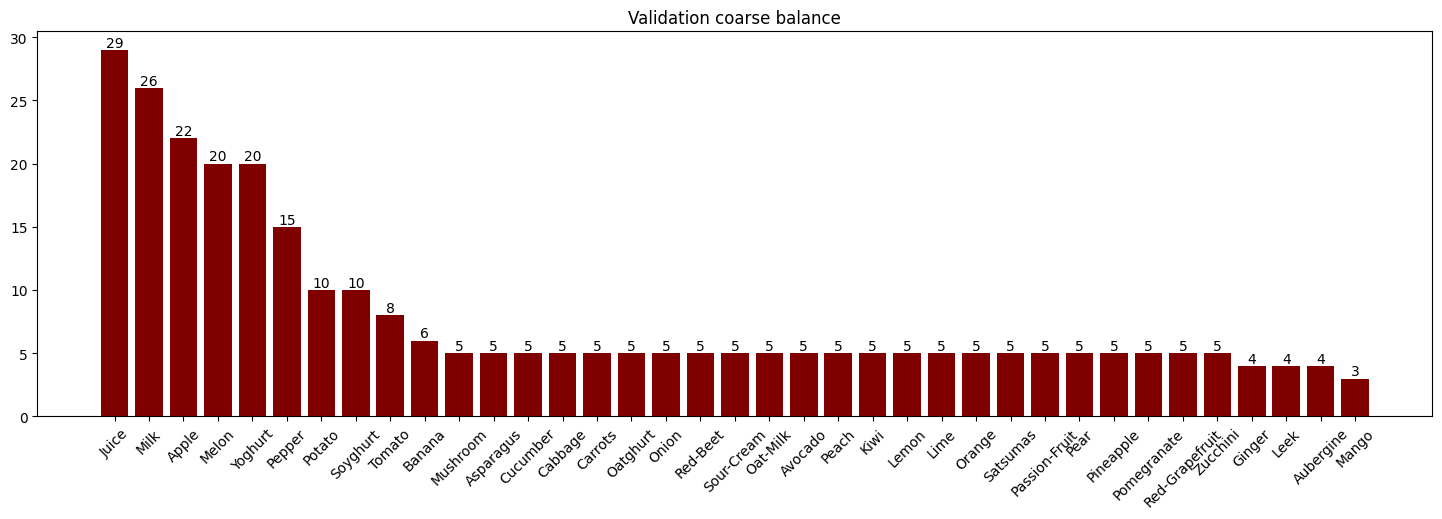

In [17]:
x=val_df['coarse_str'].value_counts()

fig, ax = plt.subplots(figsize = (18, 5))
bars = ax.bar(x.index, x.values, color ='maroon', width = 0.8)
ax.bar_label(bars)
plt.title('Validation coarse balance')
plt.xticks(rotation=45)
plt.show()

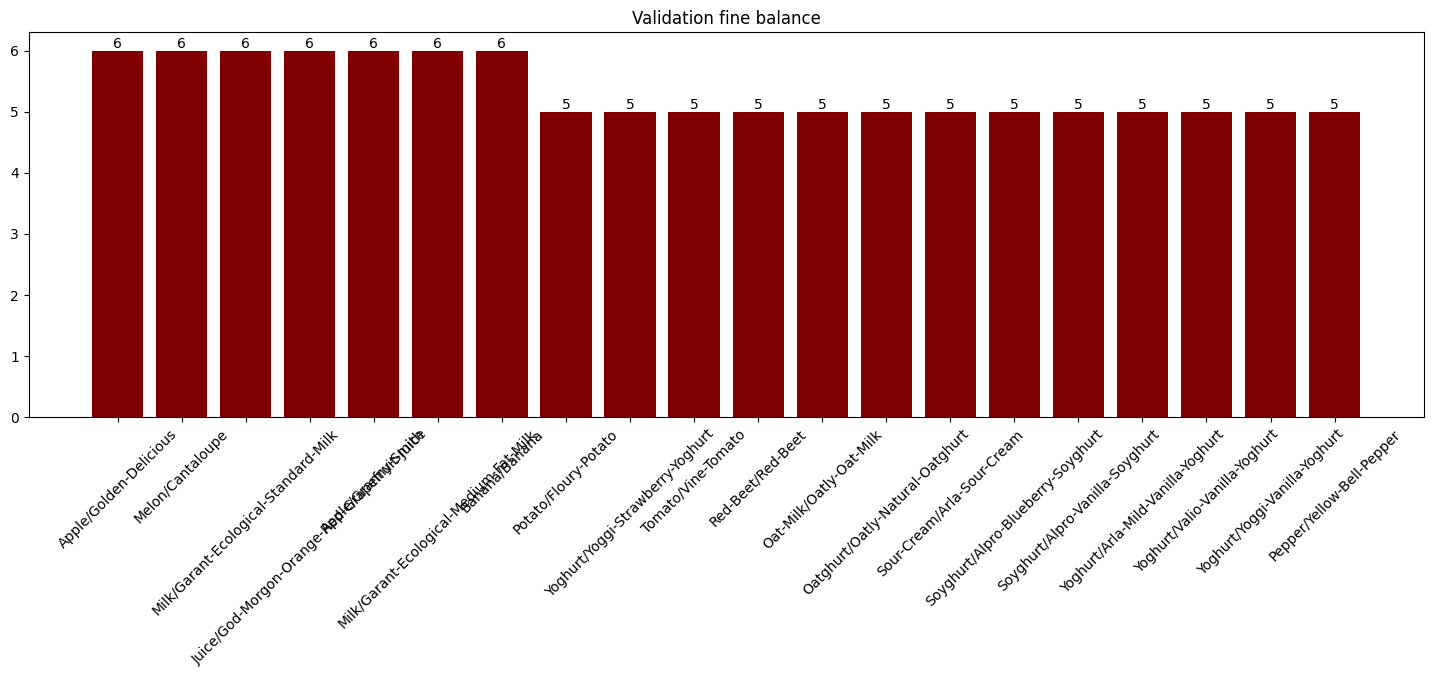

In [18]:
x=(val_df['coarse_str']+'/'+val_df['fine_str']).value_counts().head(20)

fig, ax = plt.subplots(figsize = (18, 5))
bars = ax.bar(x.index, x.values, color ='maroon', width = 0.8)
ax.bar_label(bars)
plt.title('Validation fine balance')
plt.xticks(rotation=45)
plt.show()

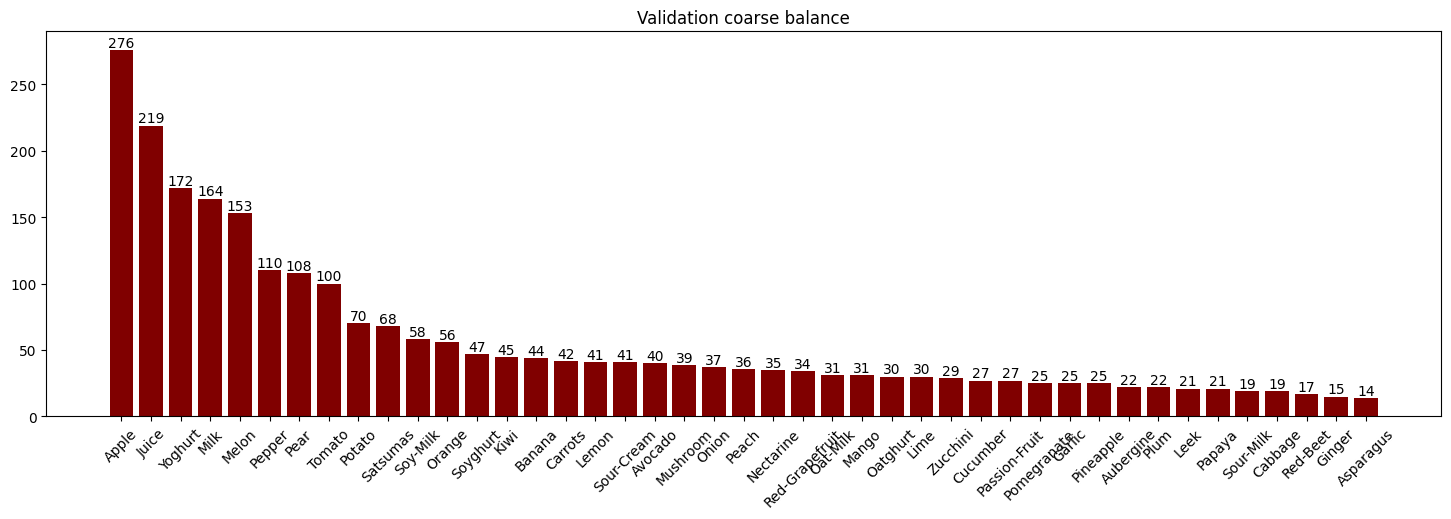

In [19]:
x=test_df['coarse_str'].value_counts()

fig, ax = plt.subplots(figsize = (18, 5))
bars = ax.bar(x.index, x.values, color ='maroon', width = 0.8)
ax.bar_label(bars)
plt.title('Validation coarse balance')
plt.xticks(rotation=45)
plt.show()

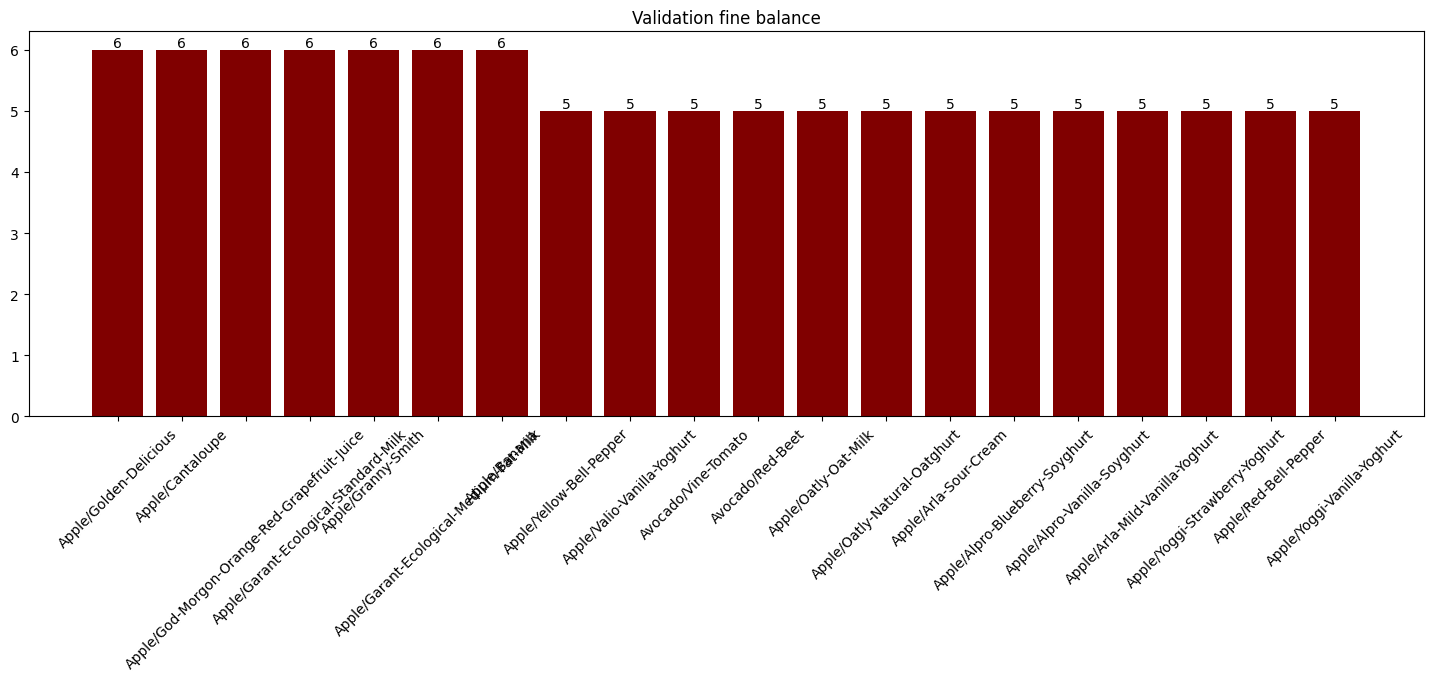

In [20]:
x=(test_df['coarse_str']+'/'+val_df['fine_str']).value_counts().head(20)

fig, ax = plt.subplots(figsize = (18, 5))
bars = ax.bar(x.index, x.values, color ='maroon', width = 0.8)
ax.bar_label(bars)
plt.title('Validation fine balance')
plt.xticks(rotation=45)
plt.show()

### curtosis

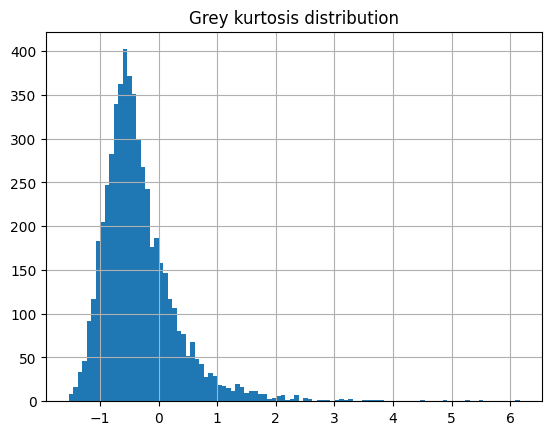

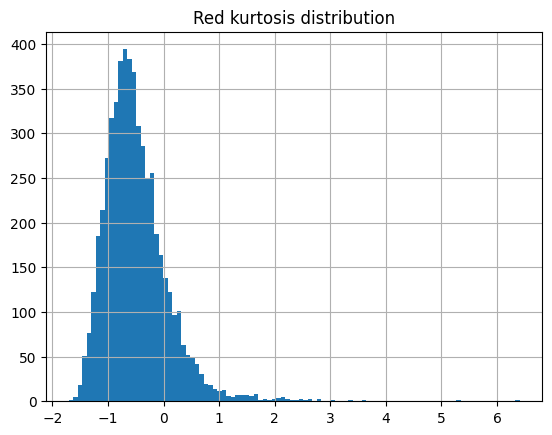

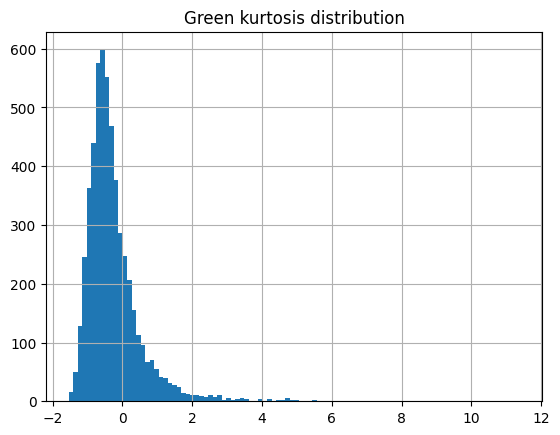

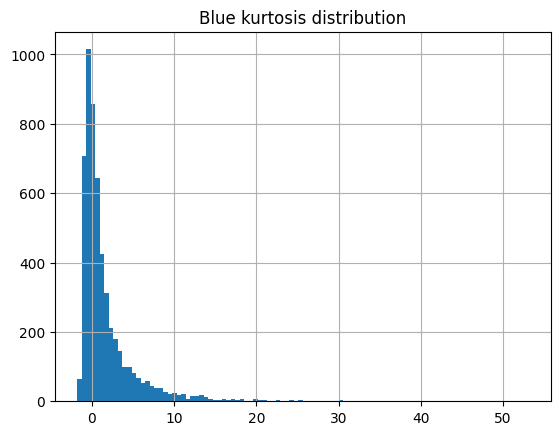

In [21]:
df=pd.concat([train_df, val_df,test_df])

df['grey_kurtosis'].hist(bins=100)
plt.title('Grey kurtosis distribution')
plt.show()
df['red_kurtosis'].hist(bins=100)
plt.title('Red kurtosis distribution')
plt.show()
df['green_kurtosis'].hist(bins=100)
plt.title('Green kurtosis distribution')
plt.show()
df['blue_kurtosis'].hist(bins=100)
plt.title('Blue kurtosis distribution')
plt.show()

## GLCM

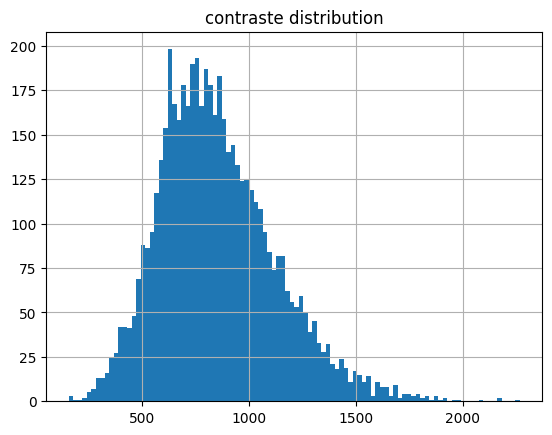

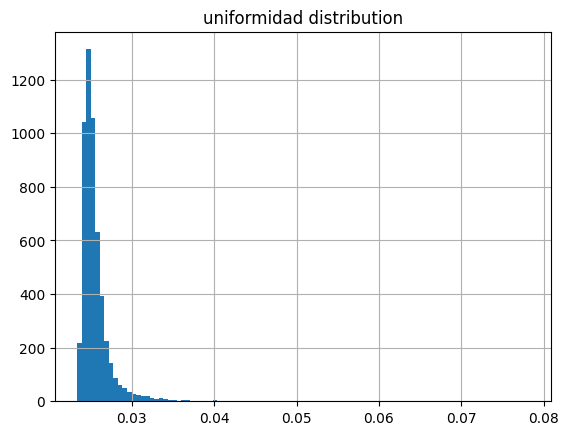

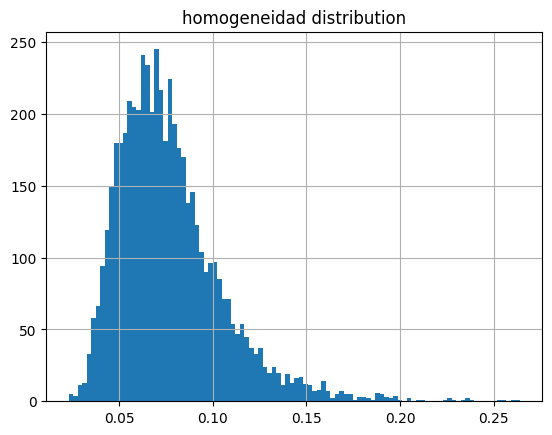

In [22]:
df['contraste'].hist(bins=100)
plt.title('contraste distribution')
plt.show()

df['uniformidad'].hist(bins=100)
plt.title('uniformidad distribution')
plt.show()

df['homogeneidad'].hist(bins=100)
plt.title('homogeneidad distribution')
plt.show()

# RandomForest

In [23]:
x_train=train_df.drop(['path','coarse','coarse_str','fine','fine_str','grey_matrix','grey','red','green','blue'],axis=1)
x_test=test_df.drop(['path','coarse','coarse_str','fine','fine_str','grey_matrix','grey','red','green','blue'],axis=1)
x_val=val_df.drop(['path','coarse','coarse_str','fine','fine_str','grey_matrix','grey','red','green','blue'],axis=1)

In [24]:
y_train=train_df['coarse']
y_test=test_df['coarse']
y_val=val_df['coarse']

In [25]:
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

modelo_rf.fit(x_train, y_train)


RandomForestClassifier(random_state=42)

Idea: Agregar media y varianza como metricas de cada filtro.

In [26]:
param_grid_rf = {
    "n_estimators": [50, 100, 150],
    "max_depth" : [3, 4, 5, 6],
    "class_weight": ["balanced", None]
}

In [37]:
grid_rf = GridSearchCV(estimator=modelo_rf, param_grid=param_grid_rf, scoring='accuracy', cv=5, return_train_score=True)
grid_rf.fit(x_test, y_test)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='accuracy')

In [38]:
# inicial {'class_weight': 'balanced', 'max_depth': 3, 'n_estimators': 50}
grid_rf.best_params_

{'class_weight': None, 'max_depth': 6, 'n_estimators': 150}

In [39]:
train_preds = grid_rf.best_estimator_.predict(x_train)
test_preds = grid_rf.best_estimator_.predict(x_test)
val_preds = grid_rf.best_estimator_.predict(x_val)

In [40]:
print("Accuracy:")
print("- Train:", accuracy_score(y_train, train_preds))
print("- Test:", accuracy_score(y_test, test_preds))
print("- Val:", accuracy_score(y_val, val_preds))
print("\nPrecision:")
print("- Train:", precision_score(y_train, train_preds,average='weighted'))
print("- Test:", precision_score(y_test, test_preds,average='weighted'))
print("- Val:", precision_score(y_val, val_preds,average='weighted'))
print("\nRecall:")
print("- Train:", recall_score(y_train, train_preds, average='weighted'))
print("- Test:", recall_score(y_test, test_preds, average='weighted'))
print("- Val:", recall_score(y_val, val_preds, average='weighted'))
print("\nF1:")
print("- Train:", f1_score(y_train, train_preds,average='weighted'))
print("- Test:", f1_score(y_test,test_preds,average='weighted'))
print("- Val:", f1_score(y_val, val_preds,average='weighted'))
print("\nROC AUC:")

y_train_proba = grid_rf.best_estimator_.predict_proba(x_train)
y_test_proba = grid_rf.best_estimator_.predict_proba(x_test)
y_val_proba = grid_rf.best_estimator_.predict_proba(x_val)
print("- Train:", roc_auc_score(y_train, y_train_proba,average='weighted', multi_class='ovo'))
print("- Test:", roc_auc_score(y_test, y_test_proba,average='weighted', multi_class='ovo'))
# print("- Val:", roc_auc_score(y_val, y_val_proba,average='weighted', multi_class='ovo'))

Accuracy:
- Train: 0.2268939393939394
- Test: 0.3927565392354125
- Val: 0.15878378378378377

Precision:
- Train: 0.15704524388694804
- Test: 0.5135875473200138
- Val: 0.09172258375820072

Recall:
- Train: 0.2268939393939394
- Test: 0.3927565392354125
- Val: 0.15878378378378377

F1:
- Train: 0.15625259973336317
- Test: 0.33457138216156923
- Val: 0.11195681336399006

ROC AUC:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Train: 0.7435787446257488
- Test: 0.943776741022074


# End